- Data used here can be collected from this website : https://www.msit.go.kr/web/msipContents/contents.do?mId=OTg3

In [18]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import statsmodels.api as sm
from fbprophet import Prophet

from scipy.stats import shapiro
from numpy.random import seed
from numpy.random import randn

from changepoint import cpt
from changepy import pelt
from changepy.costs import normal_meanvar


import warnings
warnings.simplefilter(action='ignore')

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 15})

In [23]:
data = pd.read_excel("traffic_data.xlsx", header=1)
for i in range(data.shape[0]):
    data['기간'][i] = data['기간'][i].split('.')[0] + '-'+data['기간'][i].split('.')[1]
    
data['기간'] = pd.to_datetime(data.기간)
data.set_index('기간', inplace=True)

In [24]:
data_3g = data['3G']

In [25]:
data_3g.head()

기간
2012-01-01    20707
2012-02-01    20063
2012-03-01    21627
2012-04-01    21621
2012-05-01    22165
Name: 3G, dtype: int64

## EDA를 통해 특정 시점 후부터 데이터 분포의 변화가 있다고 생각

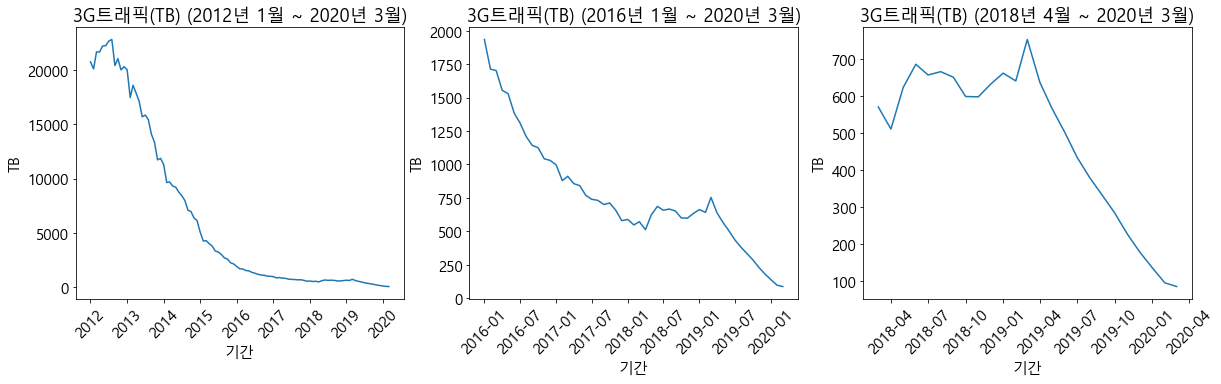

In [26]:

fig, ax = plt.subplots(1,3, figsize=(20,5));

ax[0].plot(data_3g)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set(xlabel='기간', ylabel='TB', title = '3G트래픽(TB) (2012년 1월 ~ 2020년 3월)')

ax[1].plot(data_3g['2016':])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set(xlabel='기간', ylabel='TB', title = '3G트래픽(TB) (2016년 1월 ~ 2020년 3월)')

ax[2].plot(data_3g['2018-03':])
ax[2].tick_params(axis='x', rotation=45);
ax[2].set(xlabel='기간', ylabel='TB', title = '3G트래픽(TB) (2018년 4월 ~ 2020년 3월)');



## 시계열 데이터의 분포가 변한 시점들을 찾기 위해 PELT알고리즘 사용

- PELT알고리즘은 분포 가정을 필요로 하는데 정규성 가정을 하기 위해 정규성 가정을 만족시키는 데이터로 변환

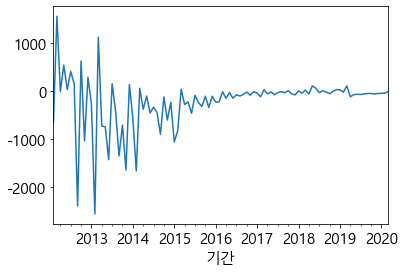

In [27]:
data_3g.diff().dropna().plot()

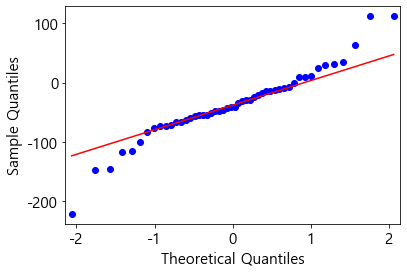

In [28]:
sm.qqplot(data_3g['2016':].diff().dropna(), line='q');

In [29]:
# seed the random number generator
seed(1)

# normality test
stat, p = shapiro(data_3g['2016':].diff().dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
    data_3g_diff_normal = data_3g['2016':].diff().dropna()
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.959, p=0.085
Sample looks Gaussian (fail to reject H0)


In [235]:
cpt_num_index = pelt(normal_meanvar(data_3g_diff_normal), len(data_3g_diff_normal))
print(cpt_num_index)

cpt_index = data_3g_diff_normal.index[cpt_num_index]
print('changepoint : ' ,cpt_index.astype(str).tolist())

[0, 1, 5, 8, 27, 29, 34, 36, 39, 42, 48]
changepoint :  ['2016-02-01', '2016-03-01', '2016-07-01', '2016-10-01', '2018-05-01', '2018-07-01', '2018-12-01', '2019-02-01', '2019-05-01', '2019-08-01', '2020-02-01']


# 모델 적합

- chagepoint들 중 하나인 '2019-02-01'을 선택. '2019-03-01'부터의 분포가 이전 시점까지의 분포와 다르다는 의미
- 1차 차분에서 '2019-03-01'부터의 분포가 이전 시점까지의 분포와 다르므로 원 데이터에서는 '2019-02-01'부터의 데이터만 활용

In [43]:
data_3g_train = data_3g['2019-02-01': ]
data_3g_train = data_3g_train.reset_index()
data_3g_train.rename(columns={'기간':'ds', '3G':'y'}, inplace=True)

data_3g_train['cap'] = data_3g_train.y.max()
data_3g_train['lower'] = 0

In [44]:
model_3g = Prophet(growth='logistic')
model_3g.fit(data_3g_train);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


In [45]:
future = model_3g.make_future_dataframe(periods=9, freq='MS')
future['cap'] = data_3g_train.y.max()
future['lower'] = 0

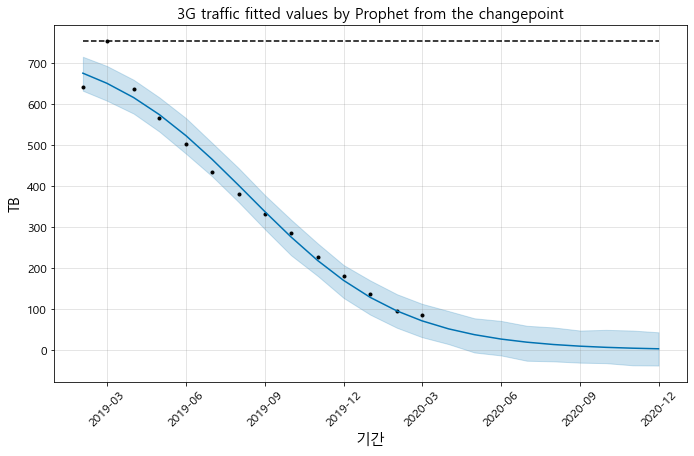

In [47]:
forecast_3g = model_3g.predict(future)
fig=model_3g.plot(forecast_3g)
plt.title('3G traffic fitted values by Prophet from the changepoint', fontsize=15)
plt.xlabel('기간', fontsize=15)
plt.ylabel('TB', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show();

## 3G 트래픽(TB) 예측

- 예측 기간 :  2020-04 ~ 2020-12
- 3G는 시간이 지날 수록 더욱 4G로 안 옮기는 사용자만 남아 트래픽 양이 감소하는 기울기가 줄어들 것이라고 예상됨.
- 데이터 포인트들의 추세로 볼 때, 고정 사용자만 남는 시기가 2020년부터로 생각이 되는데, 모델이 2020년 데이터를 3개의 관측치 밖에 학습을 하지 못했음.

In [49]:
pred_3g = forecast_3g[['ds', 'yhat']].set_index('ds').loc['2020-04-01':]
pred_3g.index.rename('기간', inplace=True)
pred_3g.rename(columns={'yhat' : '예측값'}, inplace=True)

print(pred_3g)

                  예측값
기간                   
2020-04-01  52.220043
2020-05-01  38.067384
2020-06-01  27.302979
2020-07-01  19.713368
2020-08-01  14.037071
2020-09-01   9.972987
2020-10-01   7.153237
2020-11-01   5.068525
2020-12-01   3.628685


---